# セットアップ

In [ ]:
! pip install PyMySQL

In [15]:
% matplotlib inline
import pandas as pd
import pymysql

In [16]:
connection = pymysql.connect(host='192.168.99.100',
                             user='root',
                             password='password',
                             db='yoshinani',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

In [17]:
# 各種準備
def sql(query: str):
    return  pd.read_sql_query(query, connection)

# 濃いユーザーってどんな人なのか？

## 長く使っている人

In [202]:
# 利用期間の全体傾向

q = f"""
SELECT
    U.id,
    U.created_at AS user_create,
    MAX(PM.created_at) AS pay_create,
    MAX(PT.created_at) AS par_create,
    U.updated_at AS user_update
FROM
    users U
LEFT OUTER JOIN
    payments PM
ON
    PM.paid_user_id = U.id
LEFT OUTER JOIN
    participants PT
ON
    PT.user_id = U.id
GROUP BY
    U.id
""".strip()

r = sql(q)

In [203]:
r.query('user_create < "2017-01-01 00:00:00"')[['pay_create', 'par_create']].head()

,pay_create,par_create
0,2017-07-02 14:23:34,2017-08-17 10:31:18
1,2017-06-11 11:47:51,2017-06-17 13:09:40
2,2017-07-30 22:00:48,2017-07-30 22:00:48
3,2017-05-21 01:42:22,2017-08-12 17:32:14
4,2016-08-03 14:53:01,2017-06-12 10:11:48


In [204]:
r['id'] = r['id'].apply(lambda x: int(x))

In [214]:
r['latest'] = r['user_update']
r.loc[r['latest'] < r['pay_create'], 'latest'] = r['pay_create']
r.loc[r['latest'] < r['par_create'], 'latest'] = r['par_create']
r['term'] = r['latest'] - r['user_create']
r['term'] = r['term'].apply(lambda x: int(str(x).split(' days')[0]))

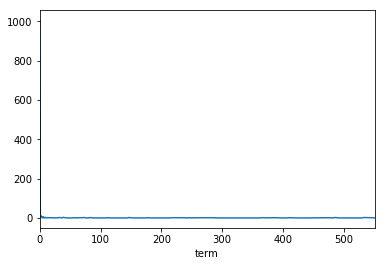

In [215]:
r.index = r['term']
r.index.names = ['Date']
r.groupby('term')['id'].count().plot()

In [216]:
r['term'].describe()

count    1199.000000
mean       24.681401
std        88.493769
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       550.000000
Name: term, dtype: float64

In [217]:
r.query('term > 0')['term'].describe()

count    194.000000
mean     152.541237
std      170.308440
min        1.000000
25%       11.250000
50%       73.000000
75%      260.000000
max      550.000000
Name: term, dtype: float64

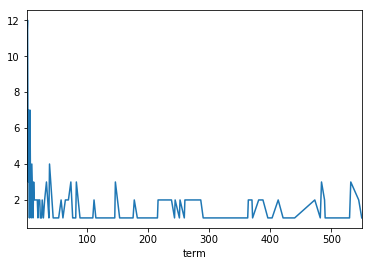

In [218]:
r.query('term > 0').groupby('term')['id'].count().plot()

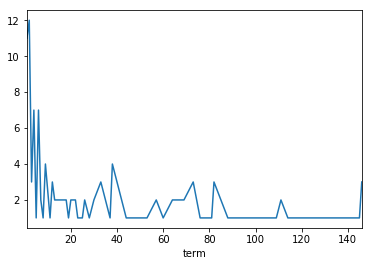

In [220]:
r.query('term > 0 & term < 150').groupby('term')['id'].count().plot()

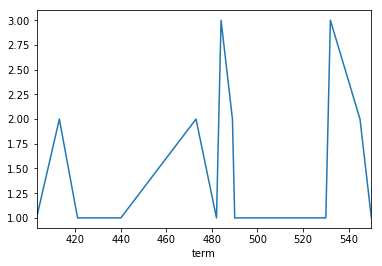

In [221]:
r.query('term > 400').groupby('term')['id'].count().plot()

In [222]:
ids = r.query('term > 400')['id'].values

q2 = f"""
SELECT
    *
FROM
    users U
WHERE
    U.id IN {tuple(ids)}
""".strip()

r2 = sql(q2)

In [ ]:
r2 # => ほとんど関係者

In [224]:
ids = r.query('term > 30')['id'].values

q3 = f"""
SELECT
    PM.event,
    PM.description,
    U1.account AS u1,
    U2.account AS u2
FROM
    participants PT
INNER JOIN
    payments PM
ON
    PT.payment_id = PM.id
INNER JOIN
    users U1
ON
    PT.user_id = U1.id
INNER JOIN
    users U2
ON
    PM.paid_user_id = U2.id
WHERE
    (PT.user_id IN {tuple(ids)} OR PM.paid_user_id IN {tuple(ids)})
    AND PM.event NOT IN ('たっつ誕生日', '本ちゃん誕生日', 'ノリさん家鍋', 'のりさん家なべ')
    AND U1.account NOT IN ('tatsu', 'kenken', 'sarashiya', 'yuichi', 'yusaku', 'nori', 'osako', 'haijima', 'matsumatsu', 'honjo', 'cauchym')
    AND U2.account NOT IN ('tatsu', 'kenken', 'sarashiya', 'yuichi', 'yusaku', 'nori', 'osako', 'haijima', 'matsumatsu', 'honjo', 'cauchym')
    AND U1.account NOT LIKE '%testuser%'
""".strip()

r3 = sql(q3)
r3

,event,description,u1,u2
0,はるか代,行き,taketo957,taketo957
1,往路飛行機,関空から那覇,yamanatsu723,yamanatsu723
2,往路飛行機,関空から那覇,taketo957,yamanatsu723
3,はるか,行き,yamanatsu723,taketo957
4,はるか,行き,taketo957,taketo957
5,トランスミッター,トランスミッター,yamanatsu723,taketo957
6,トランスミッター,トランスミッター,taketo957,taketo957
7,ホテル,沖縄残波岬ロイヤルホテル,yamanatsu723,yamanatsu723
8,ホテル,沖縄残波岬ロイヤルホテル,taketo957,yamanatsu723
9,食材費,コープ,yamanatsu723,taketo957


In [225]:
set(list(set(r3['u1'].values)) + list(set(r3['u2'].values)))

{'151MaYu151',
 '1977yy',
 '19940208',
 '3姉妹立替金',
 '5yk19',
 '812kcm',
 'Eri',
 'KSG34RYT',
 'MaYu',
 'Me-KEN',
 'Sinister',
 'TAKUMATT1',
 'UESAN',
 'a_ishii',
 'ai0416',
 'ajyanong',
 'aki1031jp',
 'akira',
 'asakomaru',
 'azumakku',
 'bbdaze',
 'cha',
 'chihosss',
 'chiru3346',
 'damr9927',
 'darumahiro',
 'dn30915',
 'ejuri',
 'erina515',
 'eritaso',
 'fairy423',
 'ferretdokodoko',
 'fujii',
 'fujiseki1982623',
 'fukuzawa45',
 'gen_rx7_fd3s',
 'hachi69',
 'henako',
 'hidnry',
 'hirokazu',
 'homahoacho',
 'hrkz0927',
 'iba1026',
 'imuuuu',
 'itaru114',
 'kanako0128',
 'kapipi7',
 'katsuqd5',
 'kazzynaks',
 'kei107',
 'kenta',
 'kentaso',
 'kina39',
 'kiyota',
 'kmk2711',
 'koko',
 'kota828',
 'krcayn',
 'ktmr',
 'kurokiti5004',
 'lisa.cb',
 'maayop',
 'machung',
 'mackey35',
 'maco',
 'makiko0525',
 'manamim',
 'martyrmart',
 'masanorisama',
 'mayu0904ds',
 'mayucita',
 'mfmf',
 'mic6884',
 'mikitea',
 'minorikawa314',
 'mochi69',
 'moe6954',
 'moechoru0926',
 'mogumoguneco',
 'momo

In [226]:
set((r3['event'] + ' @ ' + r3['description']).values)

{'交通費 @ レンタカー',
 '歯磨き粉、ゴミ袋 @ 歯磨き粉、ゴミ袋２つ',
 'デパ地下 @ デパ地下',
 'スリランカ @ スリランカ',
 '龍神の湯 @ お風呂',
 'コンビニ @ コンビニ',
 'Breakfast at Barcelona @ McDonald Prat National EUR 15.50',
 '飯田へ、、、 @ 東屋',
 'パーキングエリア @ お土産',
 '3coins @ はし',
 '高千穂あまてらす鉄道 @ 高千穂↔︎高千穂鉄橋',
 'タクシー @ ツリーオブライフ⇨ティーファクトリー',
 '電灯 @ タープ&テントのスマイルプライ',
 'ジェラート @ 前でナウオン。横でファンシーダンス。後ろでさぎり。',
 'パタット ミニ @ ポータブルチェアを手に入れた！！',
 '2016/3/4スパコミ @ 赤ブー ビックサイト',
 '昼ごはん @ 神戸屋',
 'ガス代2/20 @ 2/20締め',
 'ガスト@和光市 @ ゆきさんとRe:act作戦会議！！茶番がち〜！！',
 '食費 @ さかがみ',
 'フライパン @ フライパン',
 '南国ダイニング @ スパムポーく',
 '11月家賃 @ 1/2負担',
 '飛行機代 @ いわて花巻←→伊丹',
 '交通費 @ カーシェア',
 '返済 @ yui314314への返済',
 'A&W 那覇空港店 @ ハンバーガーセット',
 'ファミマ @ ミックスサラダ',
 '電気代 7月分 @ 電気代 7月分',
 '無老鍋 台北新生店 @ 薬膳鍋ディナー',
 '映画 @ 美女と野獣',
 '千年の宴 @ おひる',
 'つるとんたん アゲイン @ カズちゃんは何をしてもカズちゃん。かんちゃんは50オーバー！！',
 '半年記念食事 @ 巴せり',
 'ブランコビリー @ 肉',
 '初穂料 餅踏み @ 初穂料 餅踏み',
 '記念日デート @ キリンシティ',
 'ランチ、雑費諸々 @ ランチ、雑費諸々',
 '収納カゴ、紙袋 @ セリア',
 'マサズキッチン @ ランチ',
 '歯磨き粉 @ 1',
 'お菓子 @ お菓子',
 '幡ヶ谷分 @ 幡ヶ谷分',
 'ここはっと @ ここはっと',
 'バス @ 那覇空港-JALシティ',
 'ディ

In [ ]:
# 大多数のユーザーが初回登録した日には離脱してしまっている。
# 長い期間使い続けている（登録日 - 最新アクション日 > 30日 の）ユーザーのほとんどが運営者・もしくはその知人である。
# それ以外で長い期間使い続けているユーザーの用途としては「旅行」「家計簿」「デート」「飲み会」（短い間しか使っていないユーザーも同じか？）


## 頻繁に使っている人

→ TODO

## 大勢で使っている人

→ TODO